In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+403.g888aa62e6.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.55 GB available memory.


In [19]:
from desc.objectives.objective_funs import _Objective
from desc.compute.utils import _compute as compute_fun


class ForceBalanceDeflated(_Objective):
    """Radial and helical MHD force balance.

    Given force densities:

    Fᵨ = √g (J^θ B^ζ - J^ζ B^θ) - ∇ p

    Fₕₑₗᵢ √g J^ρ

    and helical basis vector:

    𝐞ʰᵉˡⁱ = B^ζ ∇ θ - B^θ ∇ ζ

    Minimizes the magnitude of the forces:

    fᵨ = Fᵨ ||∇ ρ|| dV  (N)

    fₕₑₗᵢ = Fₕₑₗᵢ ||𝐞ʰᵉˡⁱ|| dV  (N)

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium that will be optimized to satisfy the Objective.
    eqs: list of Equilibrium
        list of Equilibrium objects to use in deflation operator.
    sigma: float, optional
        sigma term in deflation operator
    power: float, optional
        power parameter in deflation operator.
    grid : Grid, optional
        Collocation grid containing the nodes to evaluate at.
        Defaults to ``ConcentricGrid(eq.L_grid, eq.M_grid, eq.N_grid)``
    params_to_deflate_with: list of str
        Which params to use in the deflation operator to define the
        state to deflate, defaults to ["Rb_mn","Zb_mn"]



    """

    __doc__ = __doc__.rstrip() + collect_docs(
        target_default="``target=0``.", bounds_default="``target=0``."
    )
    _static_attrs = _Objective._static_attrs + ["_params_to_deflate_with"]

    _equilibrium = True
    _coordinates = "rtz"
    _units = "(N)"
    _print_value_fmt = "Force error: "

    def __init__(
        self,
        eq,
        eqs,
        sigma=0.05,
        power=2,
        params_to_deflate_with=["R_lmn", "Z_lmn", "L_lmn"],
        target=None,
        bounds=None,
        weight=1,
        normalize=True,
        normalize_target=True,
        loss_function=None,
        deriv_mode="auto",
        grid=None,
        name="force",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        self._grid = grid
        self._eqs = eqs
        self._sigma = sigma
        self._power = power
        self._params_to_deflate_with = params_to_deflate_with
        super().__init__(
            things=eq,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            loss_function=loss_function,
            deriv_mode=deriv_mode,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=True, verbose=1):
        """Build constant arrays.

        Parameters
        ----------
        use_jit : bool, optional
            Whether to just-in-time compile the objective and derivatives.
        verbose : int, optional
            Level of output.

        """
        eq = self.things[0]
        if self._grid is None:
            grid = ConcentricGrid(
                L=eq.L_grid,
                M=eq.M_grid,
                N=eq.N_grid,
                NFP=eq.NFP,
                sym=eq.sym,
                axis=False,
            )
        else:
            grid = self._grid

        self._dim_f = 2 * grid.num_nodes
        self._data_keys = [
            "F_rho",
            "|grad(rho)|",
            "sqrt(g)",
            "F_helical",
            "|e^helical*sqrt(g)|",
        ]

        timer = Timer()
        if verbose > 0:
            print("Precomputing transforms")
        timer.start("Precomputing transforms")

        profiles = get_profiles(self._data_keys, obj=eq, grid=grid)
        transforms = get_transforms(self._data_keys, obj=eq, grid=grid)

        self._constants = {
            "transforms": transforms,
            "profiles": profiles,
        }

        timer.stop("Precomputing transforms")
        if verbose > 1:
            timer.disp("Precomputing transforms")

        if self._normalize:
            scales = compute_scaling_factors(eq)
            self._normalization = scales["f"]

        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        """Compute MHD force balance errors.

        Parameters
        ----------
        params : dict
            Dictionary of equilibrium degrees of freedom, eg Equilibrium.params_dict
        constants : dict
            Dictionary of constant data, eg transforms, profiles etc. Defaults to
            self.constants

        Returns
        -------
        f : ndarray
            MHD force balance error at each node (N).

        """
        if constants is None:
            constants = self.constants
        data = compute_fun(
            "desc.equilibrium.equilibrium.Equilibrium",
            self._data_keys,
            params=params,
            transforms=constants["transforms"],
            profiles=constants["profiles"],
        )
        fr = data["F_rho"] * data["|grad(rho)|"] * data["sqrt(g)"]
        fb = data["F_helical"] * data["|e^helical*sqrt(g)|"]
        keys = self._params_to_deflate_with
        # TODO: better to do only surface, or every key? seems like can obtain
        # very different results depending on if using only surf or every key, but
        # at same time, only the surface matters as far as closeness of solution
        # (the surface dictates the equilibrium, more or less)
        diffs = [
            jnp.concatenate([params[key] - eq.params_dict[key] for key in keys])
            for eq in self._eqs
        ]
        diffs = jnp.vstack(diffs)
        deflation_parameter = jnp.prod(
            1 / jnp.linalg.norm(diffs, axis=1) ** self._power + self._sigma
        )
        return jnp.concatenate([fr, fb]) * deflation_parameter

In [5]:
def set_poincare_equilibrium(eq):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [6]:
eq0 = get("W7-X")
eq_poin = set_poincare_equilibrium(eq0)  # zeta=0 surface will be fixed

for N in range(1, eq0.N + 1):
    print(f"\n\nSolving for N={N} out of {eq0.N}...\n\n")
    eq_poin.change_resolution(N=N, N_grid=2 * N)

    constraints = get_fixed_xsection_constraints(eq=eq_poin, fix_lambda=True)
    objective = ObjectiveFunction(ForceBalance(eq_poin))

    eq_poin.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=75,
        ftol=1e-3,
    );

eq_poin.surface = eq_poin.get_surface_at(rho=1)



Solving for N=1...


Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 728 ms
Timer: Objective build = 1.26 sec
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 342 ms
Timer: LinearConstraintProjection build = 5.14 sec
Number of parameters: 273
Number of objectives: 810
Timer: Initializing the optimization = 6.83 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evalu

(<Figure size 1152.21x960.176 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

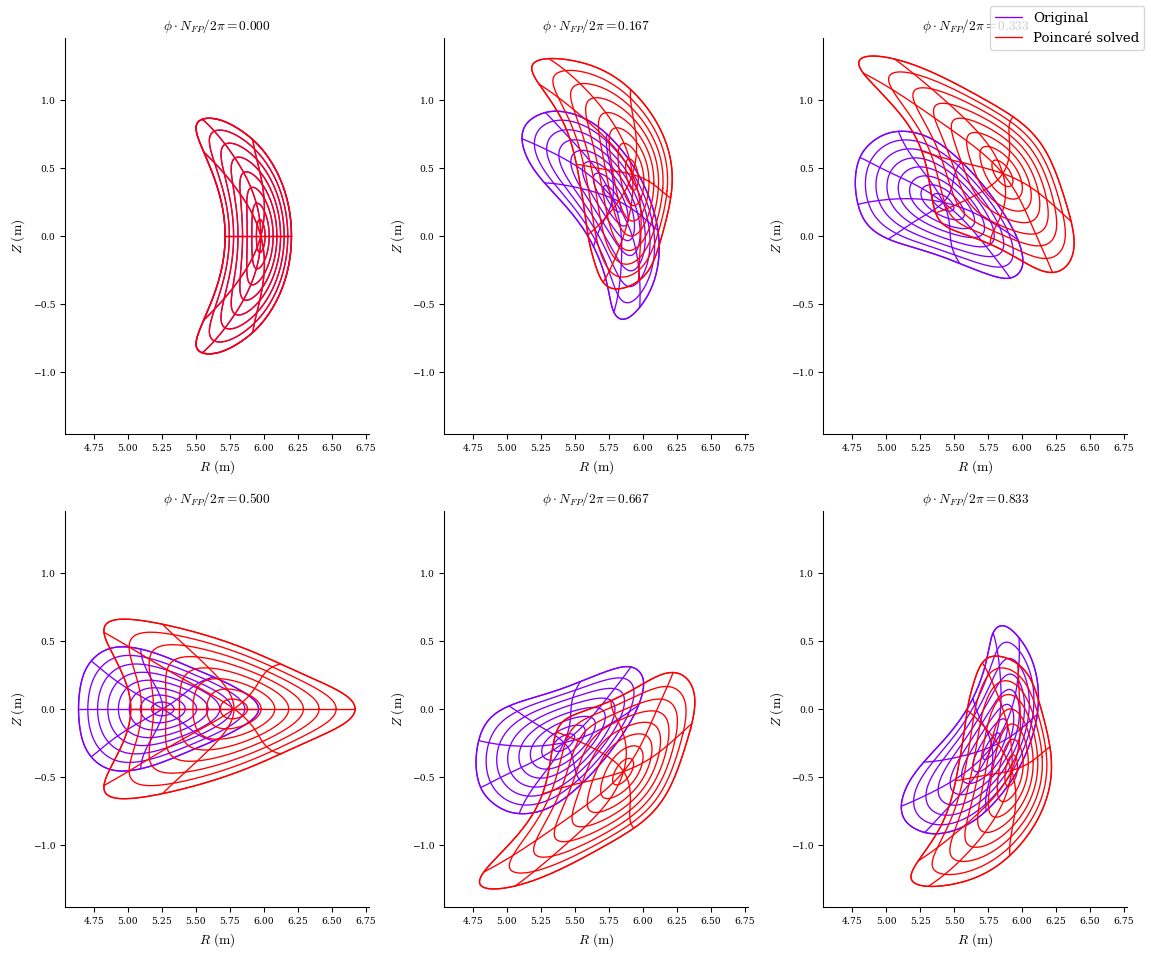

In [8]:
plot_comparison([eq0, eq_poin], labels=["Original", "Poincaré solved"])

In [9]:
eqp = set_poincare_equilibrium(eq0)  # zeta=0 surface will be fixed
constraints = get_fixed_xsection_constraints(eq=eqp, fix_lambda=True)
objective = ObjectiveFunction(ForceBalance(eqp))

eqp.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=100,
    ftol=1e-3,
)

eqp.surface = eqp.get_surface_at(rho=1)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 70.1 ms
Timer: Objective build = 82.0 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 167 ms
Timer: LinearConstraintProjection build = 2.68 sec
Number of parameters: 3276
Number of objectives: 5346
Timer: Initializing the optimization = 3.17 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Ma

In [12]:
constraints = get_fixed_xsection_constraints(eq=eqp, fix_lambda=True)
objective = ObjectiveFunction(ForceBalance(eqp))

eqp.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=100,
    ftol=1e-3,
)

eqp.surface = eqp.get_surface_at(rho=1)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 113 ms
Timer: Objective build = 150 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 267 ms
Timer: LinearConstraintProjection build = 413 ms
Number of parameters: 3276
Number of objectives: 5346
Timer: Initializing the optimization = 1.05 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximu

In [16]:
constraints = get_fixed_boundary_constraints(eq=eqp)
objective = ObjectiveFunction(ForceBalance(eqp))

eqp.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=100,
    ftol=1e-3,
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 79.8 ms
Timer: Objective build = 98.4 ms
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Timer: Objective build = 255 ms
Timer: LinearConstraintProjection build = 883 ms
Number of parameters: 2784
Number of objectives: 5346
Timer: Initializing the optimization = 1.41 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method               

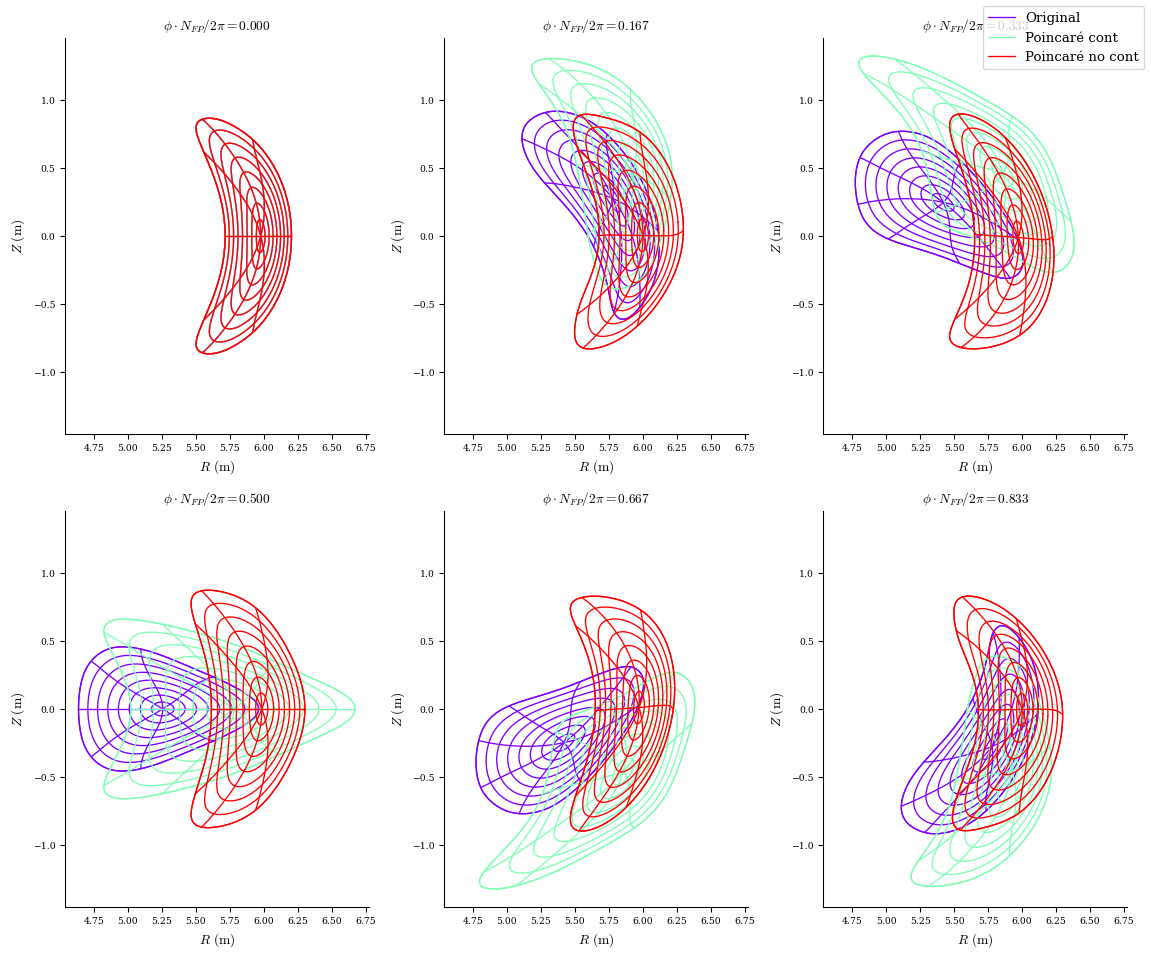

In [17]:
plot_comparison([eq0, eq_poin, eqp], labels=["Original", "Poincaré cont", "Poincaré no cont"]);

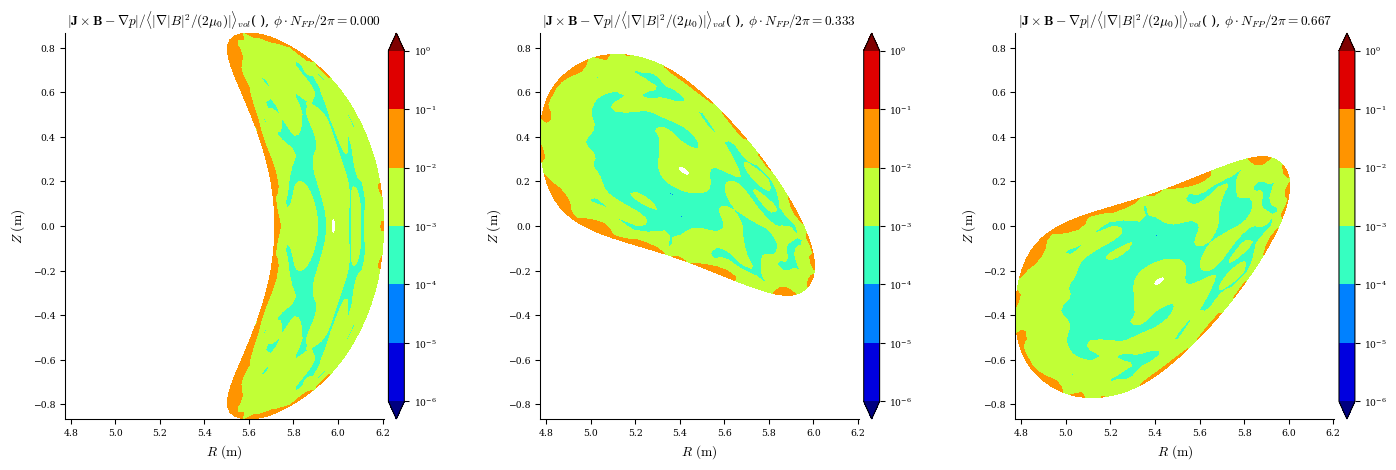

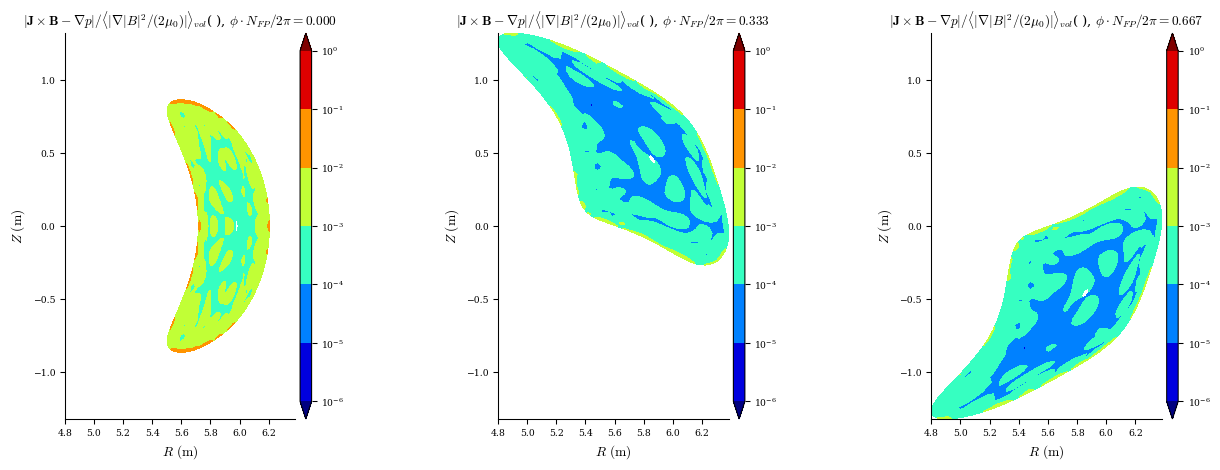

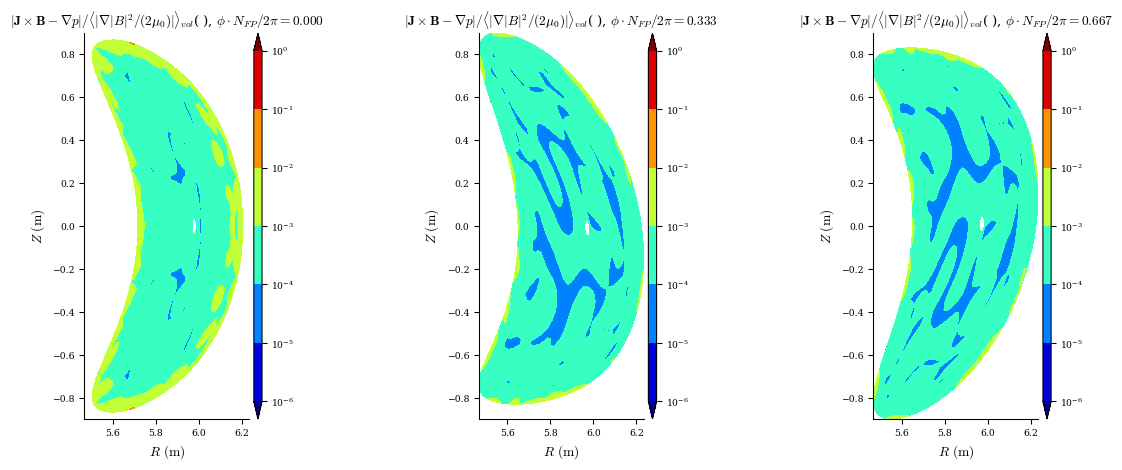

In [21]:
plot_section(eq0, "|F|_normalized", phi=3, log=True)
plot_section(eq_poin, "|F|_normalized", phi=3, log=True)
plot_section(eqp, "|F|_normalized", phi=3, log=True);

In [20]:
eqp_def1 = set_poincare_equilibrium(eq0)  # zeta=0 surface will be fixed
constraints = get_fixed_xsection_constraints(eq=eqp_def1, fix_lambda=True)
objective = ObjectiveFunction(ForceBalanceDeflated(eqp_def1, eqs=[eqp]))

eqp_def1.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=200,
    ftol=1e-3,
)

eqp_def1.surface = eqp_def1.get_surface_at(rho=1)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 77.5 ms
Timer: Objective build = 90.2 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 163 ms
Timer: LinearConstraintProjection build = 482 ms
Number of parameters: 3276
Number of objectives: 5346
Timer: Initializing the optimization = 967 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 1001
Maxim

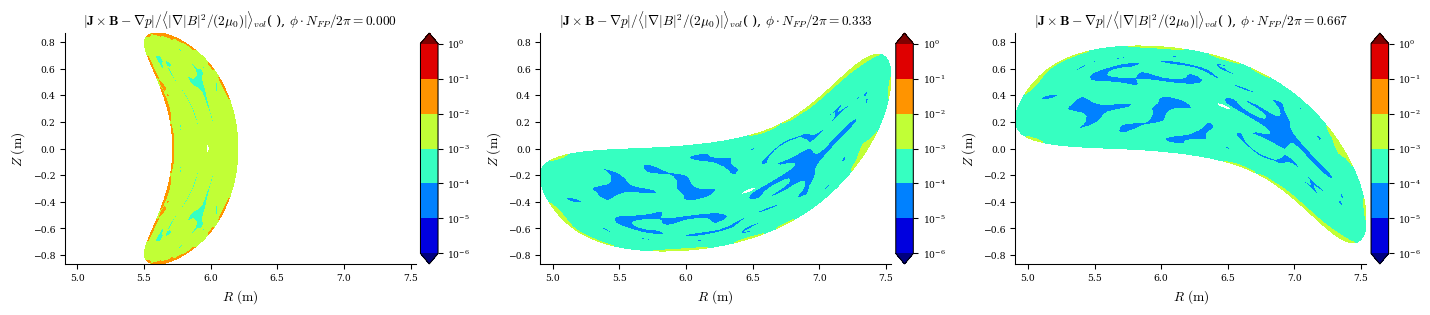

In [22]:
plot_section(eqp_def1, "|F|_normalized", phi=3, log=True);

In [25]:
eqp_def2 = set_poincare_equilibrium(eq0)  # zeta=0 surface will be fixed
constraints = get_fixed_xsection_constraints(eq=eqp_def2, fix_lambda=True)
objective = ObjectiveFunction(ForceBalanceDeflated(eqp_def2, eqs=[eqp, eqp_def1]))

eqp_def2.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=200,
    ftol=1e-3,
    gtol=0,
    xtol=0,
)

eqp_def2.surface = eqp_def2.get_surface_at(rho=1)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 76.2 ms
Timer: Objective build = 91.2 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 154 ms
Timer: LinearConstraintProjection build = 436 ms
Number of parameters: 3276
Number of objectives: 5346
Timer: Initializing the optimization = 902 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 1001
Maxim

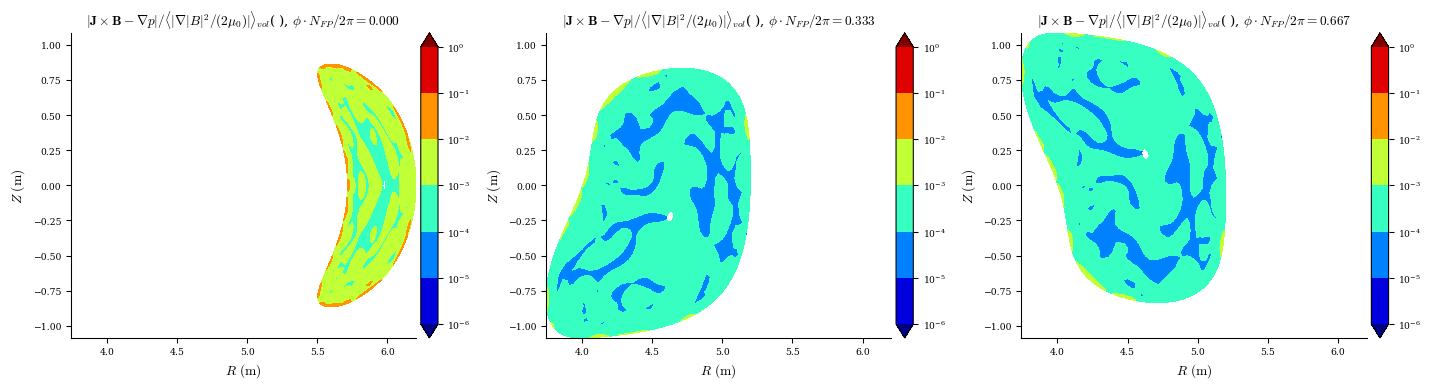

In [27]:
plot_section(eqp_def2, "|F|_normalized", phi=3, log=True);

In [28]:
eqp_def3 = set_poincare_equilibrium(eq0)  # zeta=0 surface will be fixed
constraints = get_fixed_xsection_constraints(eq=eqp_def3, fix_lambda=True)
objective = ObjectiveFunction(
    ForceBalanceDeflated(eqp_def3, eqs=[eqp, eqp_def1, eqp_def2])
)

eqp_def3.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=200,
    ftol=1e-3,
    gtol=0,
    xtol=0,
)

eqp_def3.surface = eqp_def3.get_surface_at(rho=1)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 86.0 ms
Timer: Objective build = 101 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 174 ms
Timer: LinearConstraintProjection build = 443 ms
Number of parameters: 3276
Number of objectives: 5346
Timer: Initializing the optimization = 948 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 1001
Maximu

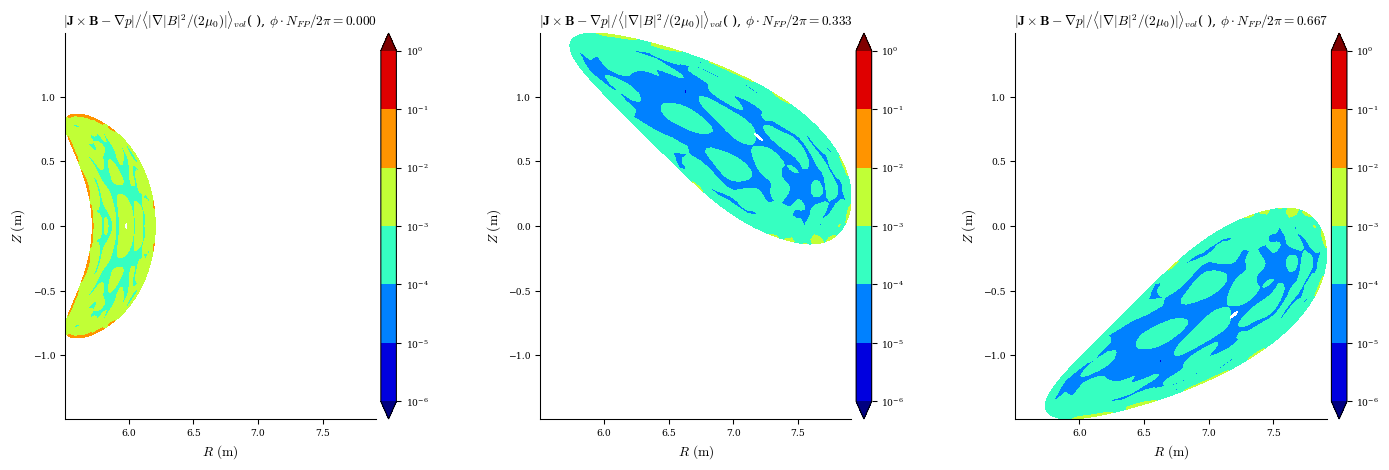

In [29]:
plot_section(eqp_def3, "|F|_normalized", phi=3, log=True);

(<Figure size 1152.21x960.176 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

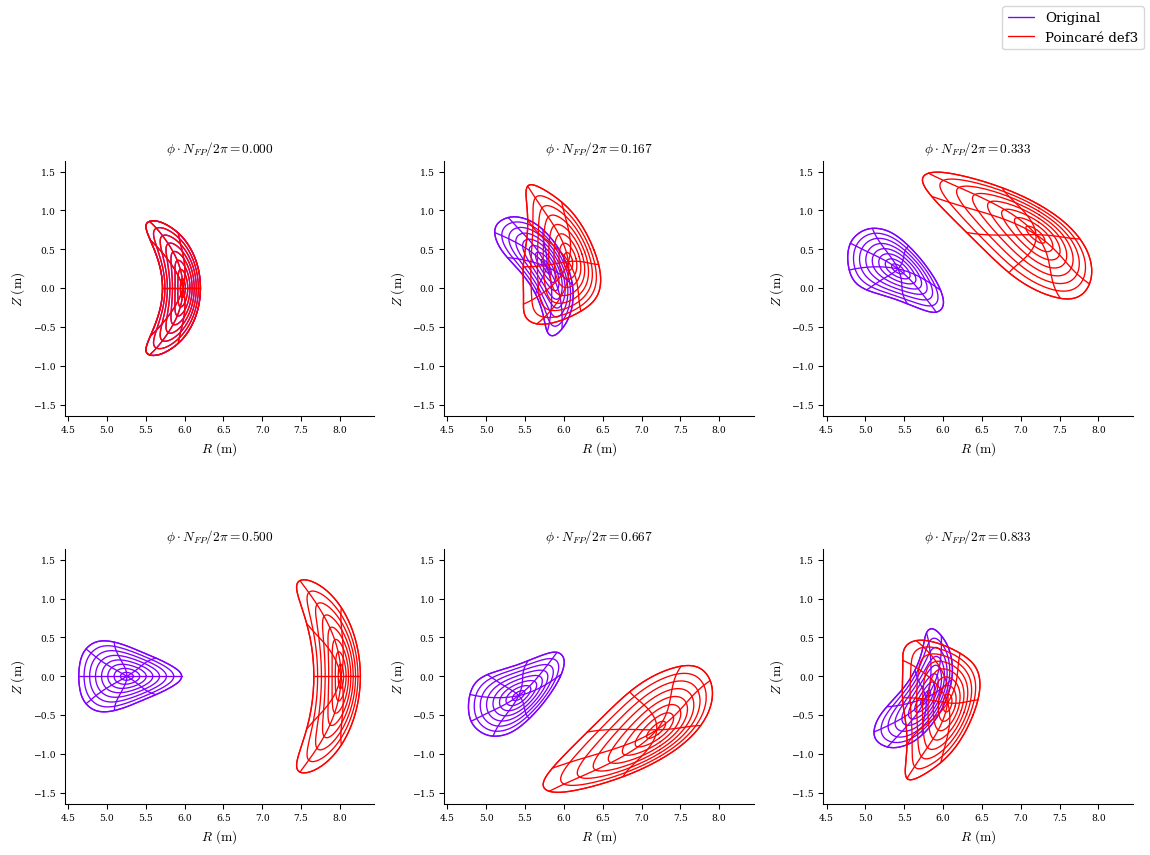

In [30]:
plot_comparison(
    [eq0, eqp_def3], labels=["Original", "Poincaré def3"]
)

(<Figure size 1152.21x960.176 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>, <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>], dtype=object))

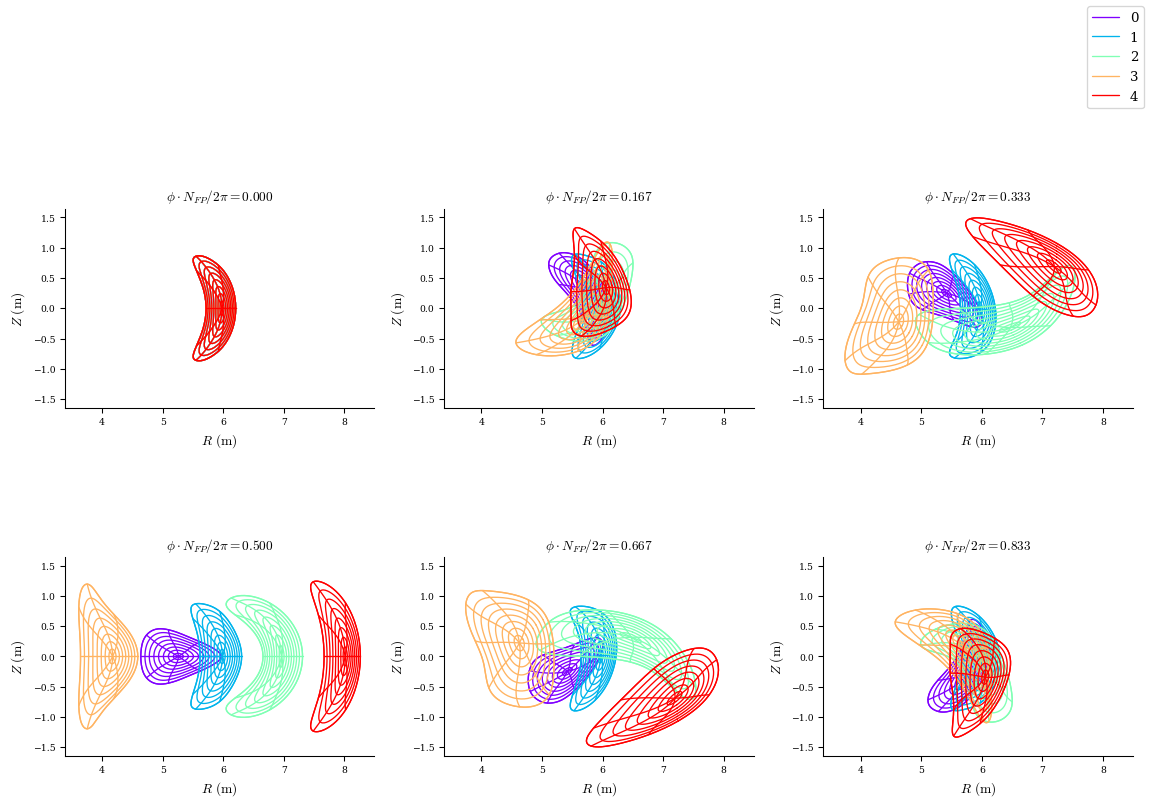

In [31]:
plot_comparison([eq0, eqp, eqp_def1, eqp_def2, eqp_def3]);

In [36]:
eq_island = desc.io.load(
    "../ISLAND_STUFF/LANDREMAN2021/eq-org/eq-org-landreman2021-island-L16M16N4.h5"
)
eq_island0 = eq_island.copy()

In [37]:
eqp_island = desc.io.load(
    "../ISLAND_STUFF/LANDREMAN2021/eq-poincare/eq-poincare-landreman2021-island-L16M16N4.h5"
)

In [40]:
constraints = get_fixed_xsection_constraints(eq=eq_island, fix_lambda=True)
objective = ObjectiveFunction(ForceBalanceDeflated(eq_island, eqs=[eqp_island]))

eq_island.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=100,
    ftol=1e-3,
    gtol=0,
    xtol=0,
)

eq_island.surface = eq_island.get_surface_at(rho=1)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 143 ms
Timer: Objective build = 455 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 306 ms
Timer: LinearConstraintProjection build = 2.97 sec
Number of parameters: 1836
Number of objectives: 9826
Timer: Initializing the optimization = 3.80 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
M

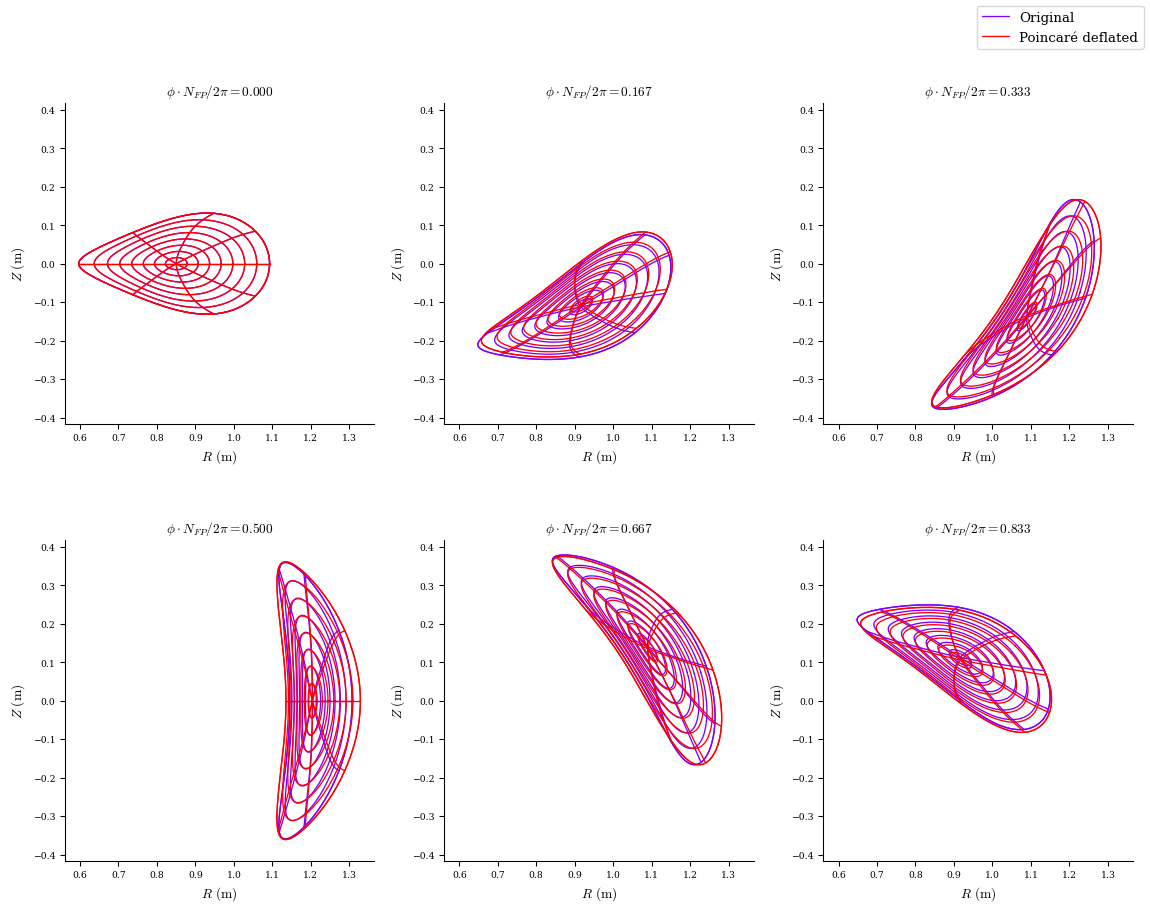

In [43]:
plot_comparison([eq_island0, eq_island], labels=["Original", "Poincaré deflated"]);

(<Figure size 384.07x384.07 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\iota ~(~)$'>)

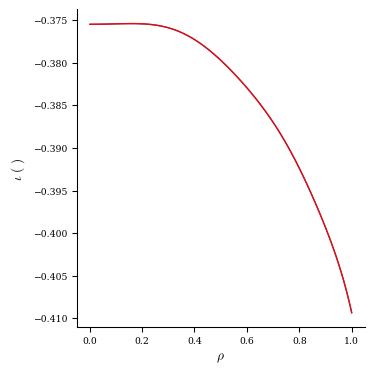

In [46]:
fig, ax = plot_1d(eq_island, "iota")
plot_1d(eq_island, "iota", ax=ax, color="red")